## Setup

Load libraries:

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from typing import Dict, Union
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV

seed=10

## Load Data

We'll load data and check the properties.

In [2]:
data = pd.read_parquet('clean_data.parquet.gzip')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6645550 entries, 0 to 6645549
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   amplitude        float64
 1   unwrapped_phase  float64
 2   coherence        float64
 3   incidence_angle  float64
 4   bare_earth_dem   float32
 5   vegetation_ht    float32
 6   wrapped_phase    float64
 7   snow_depth       float32
 8   elevation        float64
dtypes: float32(3), float64(6)
memory usage: 380.3 MB


,amplitude,unwrapped_phase,coherence,incidence_angle,bare_earth_dem,vegetation_ht,wrapped_phase,snow_depth,elevation
0,0.261970,-10.066239,0.478974,0.782536,2723.885986,1.194092,2.104467,0.370529,2724.164062
1,0.261970,-10.170159,0.528913,0.782536,2723.309082,1.335449,1.921621,0.652512,2724.658569
2,0.272913,-10.170159,0.572173,0.779307,2722.560059,2.762695,2.226624,0.652512,2725.022705
3,0.272913,-10.170159,0.572173,0.779307,2722.343018,3.000488,2.226624,0.594406,2725.022705
4,0.272913,-10.013985,0.633912,0.779307,2722.259033,2.894531,1.921621,0.626389,2725.066040


## Data Splitting

In [3]:
# First, we will divide the data into two sets: one with vegation and one without vegation

vegetation_df = data[data.vegetation_ht >= 0.5]
no_vegetation_df = data[data.vegetation_ht < 0.5].drop('vegetation_ht', axis=1)

In [4]:
def split_data(df: pd.DataFrame) -> Dict[str, pd.DataFrame]:

    """
    A function that splits the data into training (75%), testing (15%) and validation (10%) sets. 
    The function also creates a split index for hyperparameter tuning.

    Parameters:
    -----------
    df : pandas DataFrame
        A pandas DataFrame containing the data to split.

    Returns:
    --------
    A dictionary containing the training, testing and validation sets, as well as the split index.
    """

    X,y = df.drop('snow_depth', axis=1), df['snow_depth']

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.15, random_state=seed
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=1/8.5, random_state=seed
    )

    #split_index = [-1 if x in X_temp.index else 0 for x in X_train.index]
    #pds = PredefinedSplit(test_fold = split_index)

    return {
        'X_train': X_train,
        'X_test': X_test,
        'X_val': X_val,
        'X_temp': X_temp,
        'y_train': y_train,
        'y_test': y_test,
        'y_val': y_val,
        'y_temp': y_temp,
        #'split_index': split_index
    }

full_splits = split_data(data)
vegetation_splits = split_data(vegetation_df) 
no_vegetation_splits = split_data(no_vegetation_df)

## Data Exploration

* Descriptive Statistics

In [5]:
mappings=dict(zip(['full', 'vegetation', 'no_vegetation'],  [full_splits, vegetation_splits, no_vegetation_splits]))

In [6]:
for key, value in mappings.items():
    print(f"{key} data set:")
    print("---------------")
    print(f"X shape (train): {value['X_train'].shape}")
    print(f"y shape (train): {value['y_train'].shape}")
    print(f"X shape (test): {value['X_test'].shape}")
    print(f"y shape (test): {value['y_test'].shape}")
    print('')

full data set:
---------------
X shape (train): (4984162, 8)
y shape (train): (4984162,)
X shape (test): (996833, 8)
y shape (test): (996833,)

vegetation data set:
---------------
X shape (train): (2019785, 8)
y shape (train): (2019785,)
X shape (test): (403958, 8)
y shape (test): (403958,)

no_vegetation data set:
---------------
X shape (train): (2964375, 7)
y shape (train): (2964375,)
X shape (test): (592876, 7)
y shape (test): (592876,)



In [7]:
for key, value in mappings.items():
    print("=========================================")
    print(f'{key} data set descriptive statistics:')
    print("=========================================")
    display(value['X_train'].assign(snow_depth=value['y_train']).describe().T)
    print('')

full data set descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
amplitude,4984162.0,0.230878,0.181383,0.014839,0.098023,0.147296,0.327812,6.111136
unwrapped_phase,4984162.0,-8.251334,0.900462,-15.263859,-8.758814,-8.281950,-7.689599,-0.059455
coherence,4984162.0,0.571256,0.162000,0.002759,0.459518,0.593857,0.695882,0.979328
incidence_angle,4984162.0,0.869807,0.179142,0.138086,0.774225,0.904170,0.988397,1.951571
bare_earth_dem,4984162.0,3040.122559,119.670174,2490.961914,3007.156006,3031.885010,3076.604980,3157.353027
vegetation_ht,4984162.0,3.447960,5.212279,0.000000,0.000000,0.181152,6.387207,34.620117
wrapped_phase,4984162.0,-1.243848,1.300262,-3.141549,-2.139149,-1.596698,-0.758515,3.141589
elevation,4984162.0,3016.461935,114.373442,2500.195190,3012.432892,3036.392090,3084.181641,3168.000000
snow_depth,4984162.0,1.073867,0.281759,0.000168,0.900559,1.087570,1.258469,1.999924



vegetation data set descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
amplitude,2019785.0,0.389345,0.178698,0.014839,0.275690,0.351955,0.462315,6.111136
unwrapped_phase,2019785.0,-8.731681,0.809917,-15.263859,-9.175544,-8.670603,-8.233589,-0.470978
coherence,2019785.0,0.475903,0.153781,0.005907,0.364581,0.473787,0.585963,0.967077
incidence_angle,2019785.0,0.793001,0.215345,0.136859,0.649714,0.819101,0.943789,1.951571
bare_earth_dem,2019785.0,2962.711426,154.782837,2490.961914,2868.246094,3003.493896,3076.547119,3157.378906
vegetation_ht,2019785.0,8.466080,5.244898,0.500000,4.148438,8.158447,12.078125,34.620117
wrapped_phase,2019785.0,-1.031354,1.665496,-3.141509,-2.257702,-1.691171,-0.084131,3.141589
elevation,2019785.0,2969.230308,153.847218,2500.195190,2881.654053,3015.552368,3087.937866,3168.000000
snow_depth,2019785.0,1.098789,0.263303,0.000412,0.950363,1.109299,1.254563,1.999924



no_vegetation data set descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
amplitude,2964375.0,0.122865,0.069125,0.015984,0.085997,0.105445,0.133845,3.549916
unwrapped_phase,2964375.0,-7.923935,0.807417,-15.219127,-8.442478,-8.013489,-7.332197,-0.059455
coherence,2964375.0,0.636390,0.132438,0.002759,0.563398,0.656006,0.730544,0.979328
incidence_angle,2964375.0,0.922162,0.124861,0.283877,0.840303,0.940748,1.003823,1.945104
bare_earth_dem,2964375.0,3063.090088,60.579498,2492.033936,3019.783936,3035.709961,3076.626953,3157.363037
wrapped_phase,2964375.0,-1.388108,0.950335,-3.141549,-2.060339,-1.545622,-0.876308,3.141422
elevation,2964375.0,3048.597253,57.670347,2501.129150,3023.238159,3039.775757,3081.796631,3168.000000
snow_depth,2964375.0,1.057162,0.293375,0.000168,0.869309,1.066086,1.260910,1.999924


* Plotting the distribution of all variables

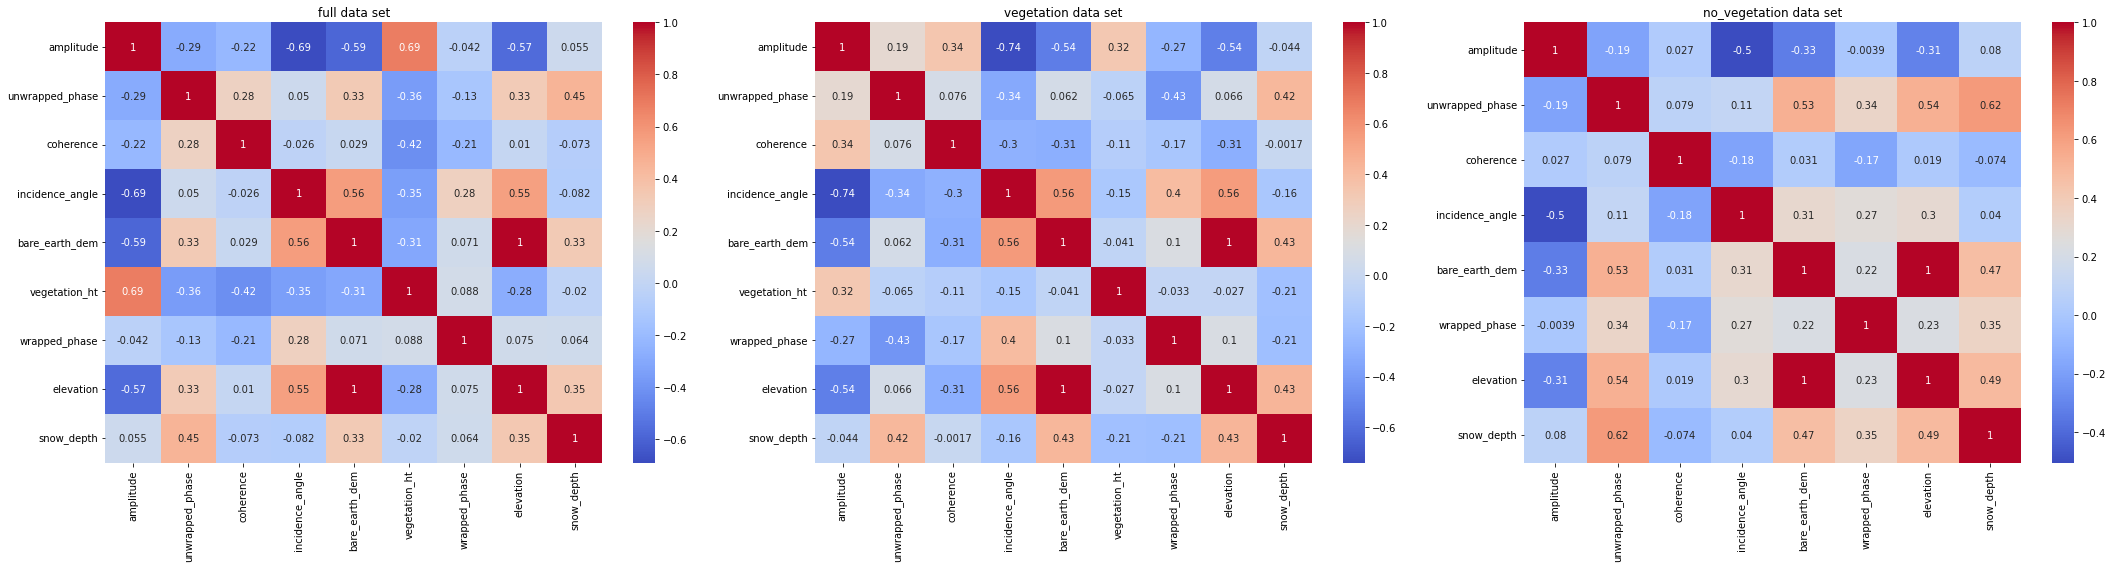

In [9]:
plt.figure(figsize=(30, 8))

for i, (key, value) in enumerate(mappings.items()):
    plt.subplot(1, 3, i+1)
    sns.heatmap(value['X_train'].assign(snow_depth=value['y_train']).corr(), cmap='coolwarm', annot=True)
    plt.title(f'{key} data set')
plt.tight_layout()

plt.savefig('plots/correlation_matrix.png')

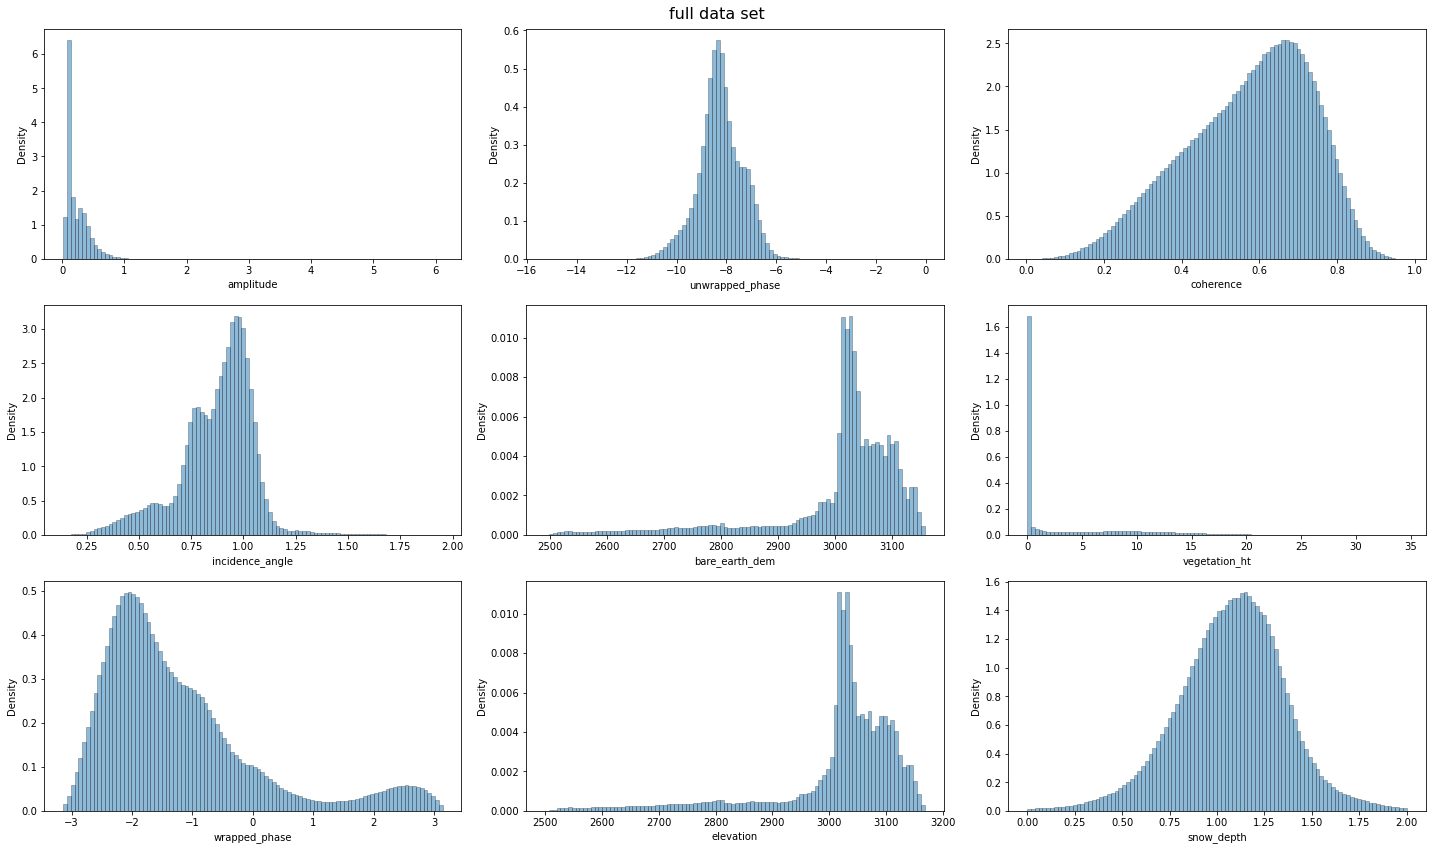

<Figure size 432x288 with 0 Axes>

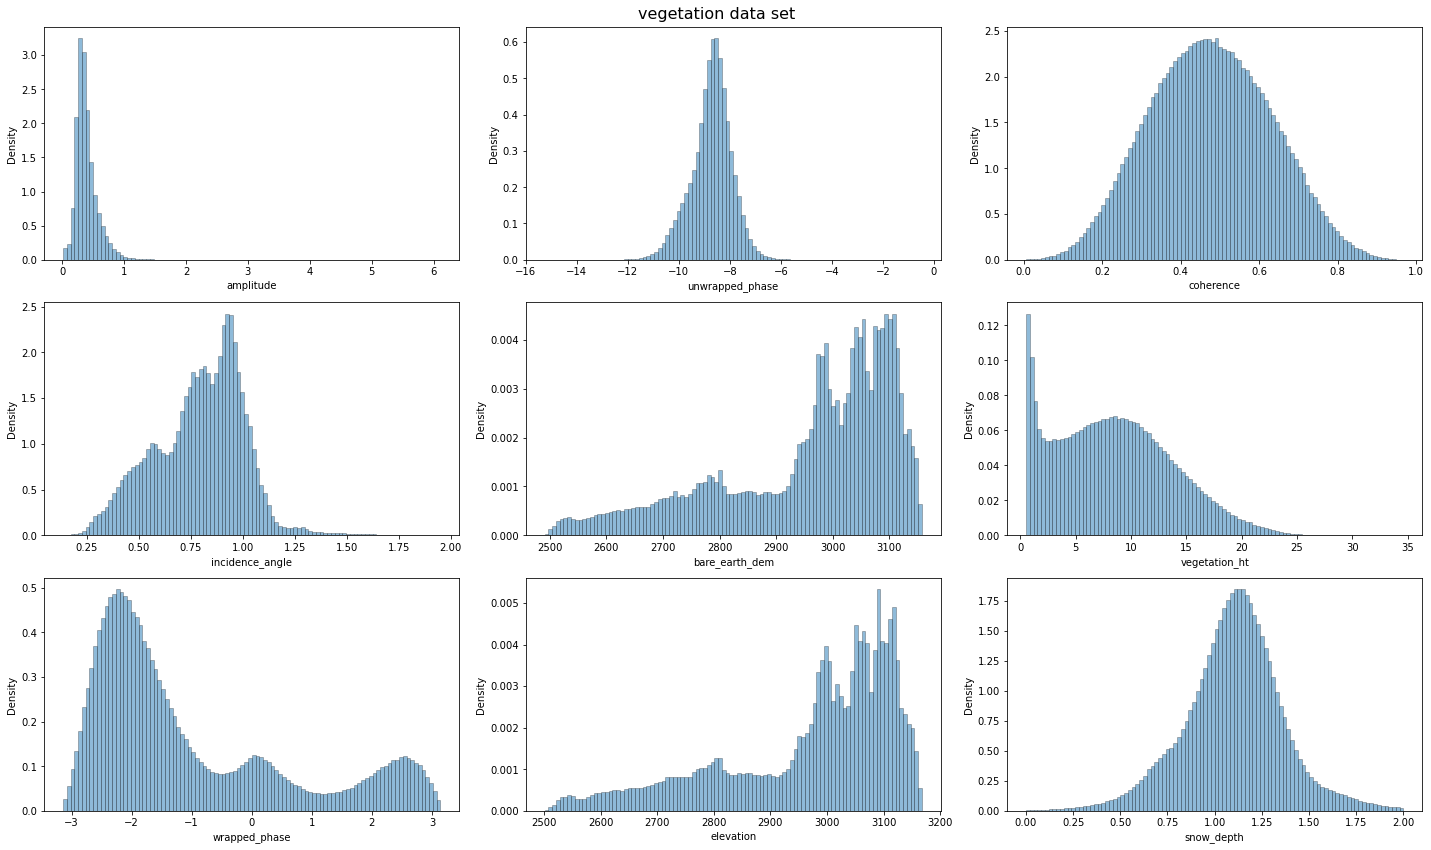

<Figure size 432x288 with 0 Axes>

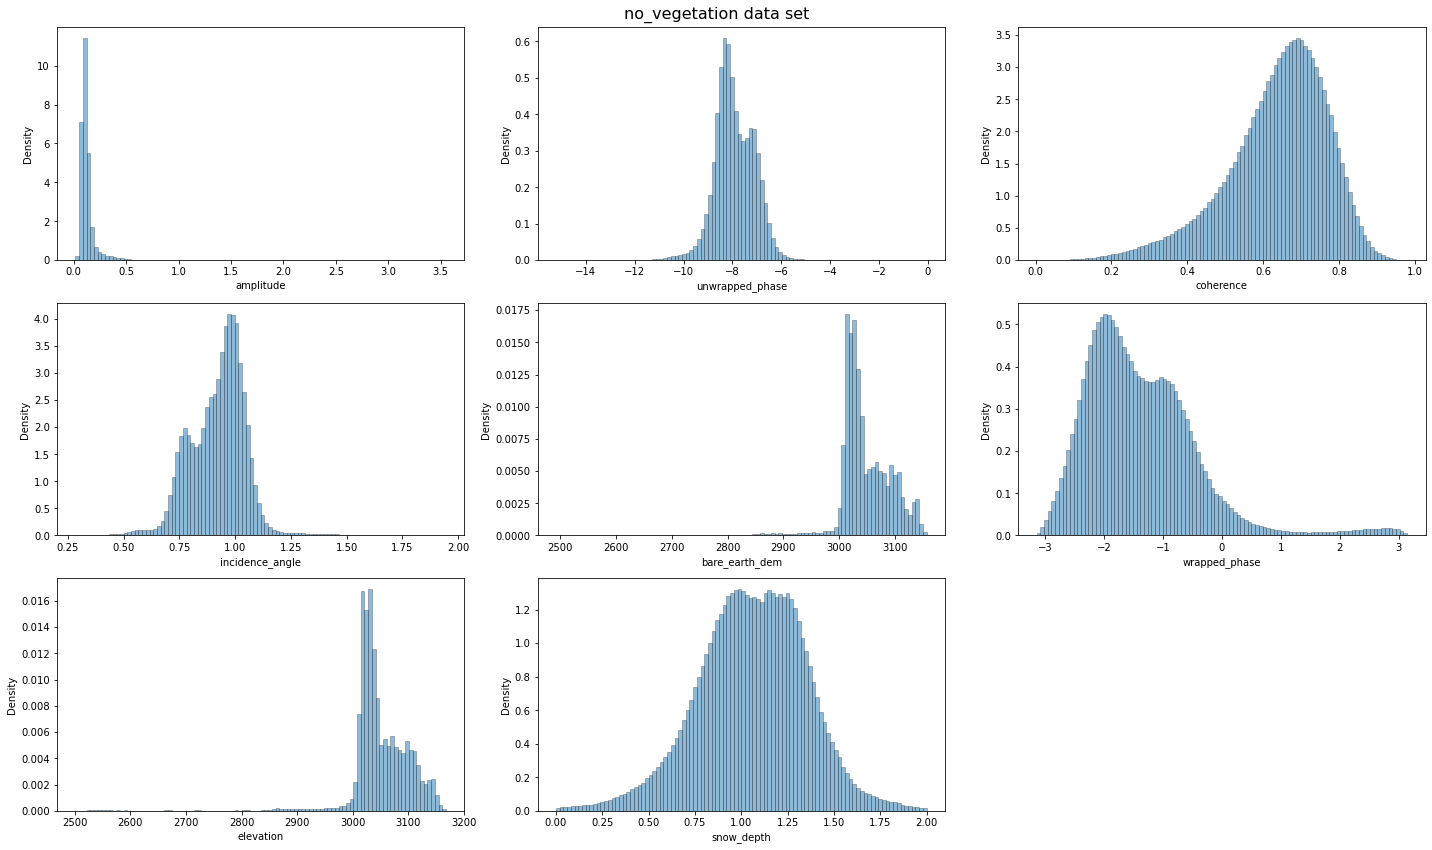

<Figure size 432x288 with 0 Axes>

In [10]:
for key, value in mappings.items():
    plt.figure(figsize=(20,12))
    combined_df = value['X_train'].assign(snow_depth=value['y_train'])
    plt.suptitle(f'{key} data set', fontsize=16)
    for i, col in enumerate(combined_df.columns):
        plt.subplot(3, 3, i+1)
        plt.hist(combined_df[col], bins=100, alpha=0.5, density=True, edgecolor='black', linewidth=0.5)
        plt.xlabel(col)
        plt.ylabel('Density')
    plt.tight_layout()
    plt.show()
    plt.savefig(f'plots/{key}_histograms.png')

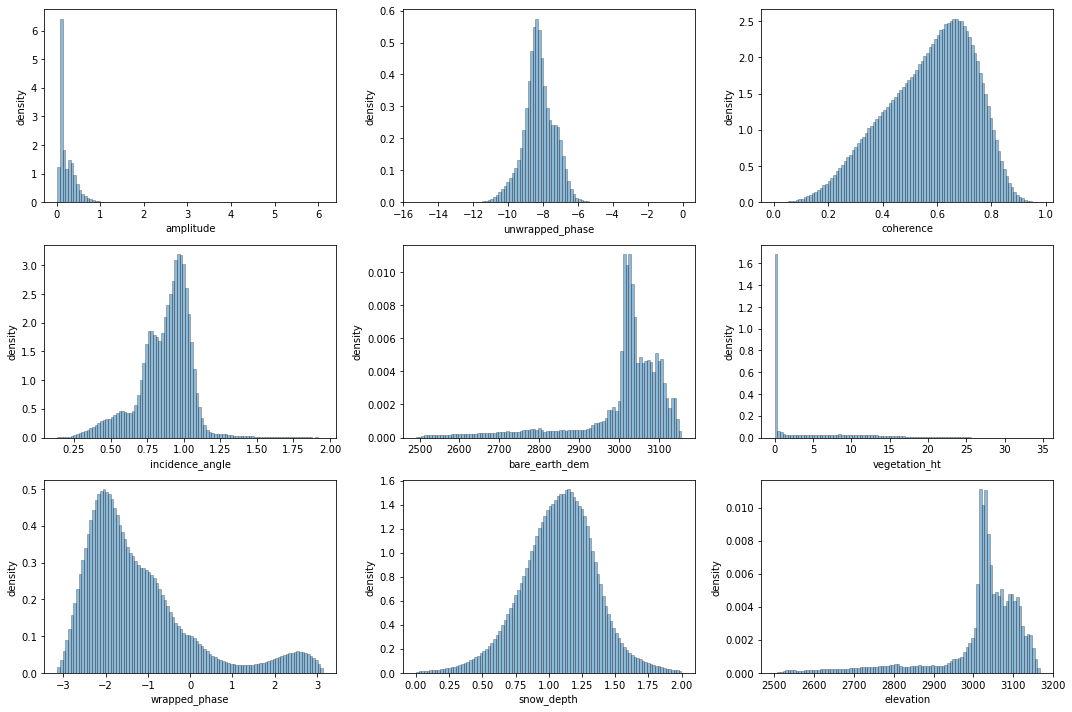

In [50]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(data.columns):
    plt.subplot(3, 3, i + 1)
    plt.hist(data[col], bins=100, alpha=0.5, density=True, edgecolor='black', linewidth=0.5)
    plt.xlabel(col)
    plt.ylabel('density')
plt.tight_layout()
plt.show()